In [1]:

import tensorflow as tf
import numpy as np
import random
import os

In [2]:
# Set a fixed seed value for reproducibility
SEED = 1
random.seed(SEED)            # Python random module
np.random.seed(SEED)         # NumPy
tf.random.set_seed(SEED)     # TensorFlow


In [3]:
# Enforce deterministic behavior for GPU operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic execution
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Deterministic cuDNN algorithms


In [4]:
# Control GPU memory allocation (prevents TensorFlow from using all GPU memory)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

# Restrict parallelism (ensures consistent execution order)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [5]:
# import os
import scipy.io #to load matlab files 
# import numpy as np
from sklearn.model_selection import train_test_split #for data splitting #, KFold
from sklearn.metrics import confusion_matrix
# import tensorflow as tf
from tensorflow.keras import layers, models #build and train CNN model
import matplotlib.pyplot as plt #for plotting confusion matrices and accuracy metrics
import seaborn as sns 
# import pandas as pd

from scipy import signal #for computing spectograms
from skimage.transform import resize #for resizing data
from sklearn.model_selection import StratifiedKFold

In [6]:
"""
# -----------------------------------------------------------------------------
# Read CWRU Bearing Data (Load - 2HP)
# -----------------------------------------------------------------------------
"""
def ImportData():
  folder_path = 'CWRU_BearingData_Load_1HP' 
  # X99_normal = scipy.io.loadmat('content/drive/MyDrive/BearingData_CaseWestern/99.mat')['X099_DE_time'] 
  file_path1 = os.path.join(folder_path, '98.mat')
  X098_normal = scipy.io.loadmat(file_path1)['X098_DE_time'] #vibration data extracted from X099_DE_time key (drive-end accelerometer data)

 

  file_path2 = os.path.join(folder_path, '110.mat')
  X110_InnerRace_007  = scipy.io.loadmat(file_path2)['X110_DE_time']
  # mat_data = scipy.io.loadmat(file_path2)
  # print(mat_data.keys())

  file_path2 = os.path.join(folder_path, '123.mat')
  X123_Ball_007  = scipy.io.loadmat(file_path2)['X123_DE_time']

  file_path3 = os.path.join(folder_path, '136.mat')
  X136_Outer_007 = scipy.io.loadmat(file_path3)['X136_DE_time']

  file_path6 = os.path.join(folder_path, '175.mat')
  X175_InnerRace_014 = scipy.io.loadmat(file_path6)['X175_DE_time']
    
  file_path7 = os.path.join(folder_path, '190.mat')
  X190_Ball_014 = scipy.io.loadmat(file_path7)['X190_DE_time']

  file_path8 = os.path.join(folder_path, '202.mat')
  X202_Outer_014  = scipy.io.loadmat(file_path8)['X202_DE_time']
    
  file_path9 = os.path.join(folder_path, '214.mat')
  X214_InnerRace_021  = scipy.io.loadmat(file_path9)['X214_DE_time']

  file_path10 = os.path.join(folder_path, '227.mat')
  X227_Ball_021  = scipy.io.loadmat(file_path10)['X227_DE_time'] 

  file_path11 = os.path.join(folder_path, '239.mat')
  X239_Outer_021  = scipy.io.loadmat(file_path11)['X239_DE_time'] 
    
  return [X098_normal,X110_InnerRace_007,X123_Ball_007,X136_Outer_007,X175_InnerRace_014,X190_Ball_014,X202_Outer_014,X214_InnerRace_021,X227_Ball_021,X239_Outer_021]

In [7]:
"""
# -----------------------------------------------------------------------------
# Data Processing and Feature Extraction
# -----------------------------------------------------------------------------
"""
# def Sampling(Data, interval_length, samples_per_block):
#     No_of_blocks = (round(len(Data)/interval_length) - round(samples_per_block/interval_length) - 1)
#     SplitData = np.zeros([No_of_blocks, samples_per_block])
#     for i in range(No_of_blocks):
#         SplitData[i,:] = Data[i*interval_length:(i*interval_length)+samples_per_block].T
#     return SplitData

#segments the time-series data into smaller blocks for processing
#data: 1D numpy array of vibration data
#interval length: step size (in samples) betweeen the start of consectuive blocks
#samples_per_block: no. of samples in each block (fixed at 1600 in the code)
#ignore_points: no. of points to skip at start and end of data(default is 0)
def Sampling(Data, interval_length, samples_per_block, ignore_points=0):
    # Adjust data length to ignore the first and last 'ignore_points'
    adjusted_length = len(Data) - 2 * ignore_points
    # Adjust the number of blocks
    No_of_blocks = (round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1)
    SplitData = np.zeros([No_of_blocks, samples_per_block]) #splitdata matrix where each row is a block of samples_per_block samples
    
    for i in range(No_of_blocks):
        # Skip the first 'ignore_points' and start sampling from that position
        start_idx = ignore_points + i * interval_length
        SplitData[i, :] = Data[start_idx:(start_idx + samples_per_block)].T #.T transpose ensure the data is correctly oriented (since the input is a column vector)
    
    return SplitData #2D array of shape - no.ofblocks, samples_per_block)


def DataPreparation(Data, interval_length, samples_per_block):
  for count,i in enumerate(Data):
    SplitData = Sampling(i, interval_length, samples_per_block) #for each dataset calls samplying to create blocks of 1600 samples
    y = np.zeros([len(SplitData),10]) #y (one-hot encoded): Shape (No_of_blocks, 10), where the column corresponding to the class is set to 1 (e.g., for class 0, [1, 0, 0, ..., 0])
    y[:,count] = 1
    y1 = np.zeros([len(SplitData),1]) #y1 (integer labels): Shape (No_of_blocks, 1), where each element is the class index (0 to 9).
    y1[:,0] = count 
    # Stack up and label the data   
    if count==0:
      X = SplitData
      LabelPositional = y
      Label = y1
    else:
      X = np.append(X, SplitData, axis=0)
      LabelPositional = np.append(LabelPositional,y,axis=0)
      Label = np.append(Label,y1,axis=0)
  print(X)
  return X, LabelPositional, Label

In [8]:
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

def generate_spectrogram_image(data_y_vector, image_shape):
    """
    Calculate the spectrogram of an array data_y_vector and resize it in 
    the image_shape resolution
    """
    fs = 48000
    # data_y_vector_len = np.shape(data_y_vector)[0]

    f, t, sxx = signal.spectrogram(
        data_y_vector,
        fs)

    sxx = min_max_norm(sxx)
    sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)

    return sxx

In [9]:
Data = ImportData()
for i, d in enumerate(Data):
    print(f"Dataset {i+1} shape: {d.shape}")
interval_length = 320 #320 #290 #200  
samples_per_block = 1296 #1600 # #1650-25*2


# Y_CNN is of shape (n, 10) representing 10 classes as 10 columns. In each sample, for the class to which it belongs, 
# the corresponding column value is marked 1 and the rest as 0, facilitating Softmax implementation in CNN 
# Y is of shape (m, 1) where column values are between 0 and 9 representing the classes directly. - 1-hot encoding
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block) 


print('Shape of Input Data =', X.shape)
print('Shape of Label Y_CNN =', Y_CNN.shape)
print('Shape of Label Y =', Y.shape)

# XX = {'X':X}
# scipy.io.savemat('Data.mat', XX)


Dataset 1 shape: (483903, 1)
Dataset 2 shape: (486224, 1)
Dataset 3 shape: (487384, 1)
Dataset 4 shape: (486804, 1)
Dataset 5 shape: (381890, 1)
Dataset 6 shape: (486224, 1)
Dataset 7 shape: (484483, 1)
Dataset 8 shape: (485063, 1)
Dataset 9 shape: (486804, 1)
Dataset 10 shape: (489125, 1)
[[ 0.046104   -0.03713354 -0.089496   ... -0.07781354 -0.05570031
  -0.04485231]
 [-0.09053908 -0.08115138 -0.05653477 ... -0.14185846 -0.08073415
  -0.021696  ]
 [ 0.03546462  0.03859385  0.06133292 ...  0.02712     0.046104
   0.03275262]
 ...
 [-0.022536    0.03922933  0.08179733 ...  0.16109067  0.055088
  -0.06176533]
 [ 0.35473333  0.26876267  0.21868267 ...  0.145232    0.095152
   0.03839467]
 [ 0.030048   -0.00584267 -0.02670933 ... -0.07595467 -0.117688
  -0.16359467]]
Shape of Input Data = (14817, 1296)
Shape of Label Y_CNN = (14817, 10)
Shape of Label Y = (14817, 1)


In [10]:
"""
# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Training
# -----------------------------------------------------------------------------
"""

## 2-Dimensional Convolutional Neural Network Classification

# Reshape the data - 2 dimensional feed 
Input_2D = X.reshape([-1,36,36,1])

# Input_2D = X_image.reshape([-1,96,96,1])
print(Input_2D.shape)

# Test-Train Split 
X_2D_train, X_2D_test, y_2D_train, y_2D_test, y_label_train, y_label_test = train_test_split(Input_2D, Y_CNN, Y, train_size=0.8, test_size=0.2, random_state=42, stratify=Y)
#(ensuring class balance via stratify=Y)
# X_2D_train, X_2D_test, y_2D_train, y_2D_test = train_test_split(Input_2D, Y_CNN, train_size=0.8, test_size=0.2, random_state=42, shuffle=True)

# Define the CNN Classification model
class CNN_2D():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        # layers.Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding ='same',activation='relu'),
        layers.Conv2D(filters=16, kernel_size=(3,3), padding='same',activation='relu', input_shape=(36,36,1)),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=32, kernel_size=(3,3), padding ='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=64, kernel_size=(3,3),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3,3),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Flatten(),
        layers.Dense(100,activation='relu'),
        layers.Dense(50,activation='relu'),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model

(14817, 36, 36, 1)


In [11]:
# k-fold cross validation / 5 fold cross validation )
kSplits = 5
# kfold = KFold(n_splits=kSplits, random_state=42, shuffle=True)
kfold = StratifiedKFold(n_splits=kSplits, random_state=42, shuffle=True) # splits training data into 5 folds - class balance(stratify)

# File path name to save best models
foldername = "CNN2D_results/V4_2_NOL_exp8/"

from tensorflow.keras.callbacks import ModelCheckpoint #Saves the model with the highest validation accuracy for each fold
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import load_model 

accuracy_train = []
accuracy_val = []
accuracy_test = []
pred_all_val = np.zeros([len(X_2D_train),10])
y_2D_val = np.zeros([len(X_2D_train),10])
kfold_test_len = []

fl1 = 0
k = 1

early_stop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True) #Stops training if validation accuracy doesn’t improve for 50 epochs, restoring the best weights.

# Train the model 
# for train, test in kfold.split(X_2D_train,y_2D_train):
for fold, (train, test) in enumerate(kfold.split(X_2D_train, y_label_train)):   

  # Define where to save the best model
  checkpoint_filepath = foldername + "best_model_" + str(k) + ".h5"
    
  # Create a ModelCheckpoint callback
  checkpoint = ModelCheckpoint(
      filepath=checkpoint_filepath,
      monitor='val_accuracy',  # Monitor validation accuracy
      save_best_only=True,  # Save only the best model
      mode='max',  # Maximize accuracy
      verbose=1
  )        

#For each fold, trains a new CNN model on the training subset (X_2D_train[train], y_2D_train[train]) for up to 200 epochs.
  Classification_2D = CNN_2D()
  # history = Classification_2D.model.fit(X_2D_train[train], y_2D_train[train], verbose=1, epochs=50) #epochs=12
  history = Classification_2D.model.fit(
        X_2D_train[train], y_2D_train[train],
        validation_data=(X_2D_train[test], y_2D_train[test]),  # Validation set for monitoring
        epochs=200,
        verbose=1,
        callbacks=[checkpoint, early_stop]  # Save the best model
  )
  
  print("Best model saved at:", checkpoint_filepath)
  CNN_2D_best_model = load_model(checkpoint_filepath)
  print("Best model loaded successfully!")
  
  fl2 = fl1 + len(test)
  pred_all_val[fl1:fl2,:] = CNN_2D_best_model.predict(X_2D_train[test])
  y_2D_val[fl1:fl2,:] = y_2D_train[test]
  kfold_test_len.append(fl2-fl1)
  fl1 = fl2  

  # Evaluate the accuracy of the model on the training set 
  train_loss, train_accuracy = CNN_2D_best_model.evaluate(X_2D_train[train], y_2D_train[train]) 
  accuracy_train.append(train_accuracy)
  
  # Evaluate the accuracy of the model on the validation set 
  val_loss, val_accuracy = CNN_2D_best_model.evaluate(X_2D_train[test], y_2D_train[test]) 
  accuracy_val.append(val_accuracy)
  
  # Evaluate the accuracy of the model on the validation set 
  test_loss, test_accuracy = CNN_2D_best_model.evaluate(X_2D_test, y_2D_test) 
  accuracy_test.append(test_accuracy)  
  
  # Evaluate the accuracy of the model on the training set 
  # kf_loss, kf_accuracy = Classification_2D.model.evaluate(X_2D_train[test], y_2D_train[test]) 
  # accuracy_2D.append(kf_accuracy)
  
  k = k + 1

/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-10 08:26:30.306462: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 08:26:30.307035: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4736 - loss: 1.3919

2025-06-10 08:26:51.107582: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 08:26:51.108544: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.84901, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_1.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - accuracy: 0.4743 - loss: 1.3901 - val_accuracy: 0.8490 - val_loss: 0.4457
Epoch 2/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8611 - loss: 0.3658
Epoch 2: val_accuracy improved from 0.84901 to 0.89161, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_1.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.8611 - loss: 0.3656 - val_accuracy: 0.8916 - val_loss: 0.2884
Epoch 3/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8957 - loss: 0.2734
Epoch 3: val_accuracy improved from 0.89161 to 0.92450, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_1.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8957 - loss: 0.2733 - val_accuracy: 0.9245 - val_loss: 0.1902
Epoch 4/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9278 - loss: 0.1818
Epoch 4: val_accuracy improved from 0.92450 to 0.94180, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_1.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.9278 - loss: 0.1818 - val_accuracy: 0.9418 - val_loss: 0.1463
Epoch 5/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9423 - loss: 0.1500
Epoch 5: val_accuracy improved from 0.94180 to 0.94391, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_1.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.9423 - loss: 0.1500 - val_accuracy: 0.9439 - val_loss: 0.1495
Epoch 6/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9507 - loss: 0.1284
Epoch 6: val_accuracy improved from 0.94391 to 0.96499, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_1.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.9507 - loss: 0.1283 - val_accuracy: 0.9650 - val_loss: 0.0946
Epoch 7/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9627 - loss: 0.1000
Epoch 7: val_accuracy did not improve from 0.96499
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9627 - loss: 0.1000 - val_accuracy: 0.9642 - val_loss: 0.0867
Epoch 8/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9683 - loss: 0.0830
Epoch 8: val_accuracy did not improve from 0.96499
297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.9683 - loss: 0.0830 - val_accuracy: 0.9401 - val_loss: 0.1623
Epoch 9/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9673 - loss: 0.1015
Epoch 9: val_accuracy did not improve from 0.96499
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9673 - loss: 0.1014 - val_accuracy: 0.9608 - val_loss: 0.0952
Epoch 10/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9793 - loss: 0.0564
Epoch 10: val_accu

297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.9793 - loss: 0.0564 - val_accuracy: 0.9793 - val_loss: 0.0525
Epoch 11/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9819 - loss: 0.0503
Epoch 11: val_accuracy did not improve from 0.97933
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9819 - loss: 0.0504 - val_accuracy: 0.9616 - val_loss: 0.1021
Epoch 12/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9831 - loss: 0.0511
Epoch 12: val_accuracy did not improve from 0.97933
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9831 - loss: 0.0511 - val_accuracy: 0.9684 - val_loss: 0.0831
Epoch 13/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9806 - loss: 0.0529
Epoch 13: val_accuracy did not improve from 0.97933
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9806 - loss: 0.0528 - val_accuracy: 0.9469 - val_loss: 0.1507
Epoch 14/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9839 - loss: 0.0443
Epoch 14: va

297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9839 - loss: 0.0530 - val_accuracy: 0.9873 - val_loss: 0.0346
Epoch 19/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9916 - loss: 0.0218
Epoch 19: val_accuracy did not improve from 0.98735
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.9916 - loss: 0.0219 - val_accuracy: 0.9819 - val_loss: 0.0468
Epoch 20/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9955 - loss: 0.0157
Epoch 20: val_accuracy improved from 0.98735 to 0.98903, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_1.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9955 - loss: 0.0157 - val_accuracy: 0.9890 - val_loss: 0.0396
Epoch 21/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9920 - loss: 0.0244
Epoch 21: val_accuracy did not improve from 0.98903
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9920 - loss: 0.0244 - val_accuracy: 0.9793 - val_loss: 0.0605
Epoch 22/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9957 - loss: 0.0135
Epoch 22: val_accuracy did not improve from 0.98903
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9957 - loss: 0.0135 - val_accuracy: 0.9852 - val_loss: 0.0441
Epoch 23/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9945 - loss: 0.0158
Epoch 23: val_accuracy did not improve from 0.98903
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9945 - loss: 0.0159 - val_accuracy: 0.9739 - val_loss: 0.0974
Epoch 24/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9896 - loss: 0.0294
Epoch 24: va

297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9964 - loss: 0.0144 - val_accuracy: 0.9907 - val_loss: 0.0328
Epoch 28/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9931 - loss: 0.0205
Epoch 28: val_accuracy did not improve from 0.99072
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9931 - loss: 0.0205 - val_accuracy: 0.9831 - val_loss: 0.0525
Epoch 29/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9986 - loss: 0.0049
Epoch 29: val_accuracy did not improve from 0.99072
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9986 - loss: 0.0049 - val_accuracy: 0.9899 - val_loss: 0.0295
Epoch 30/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9988 - loss: 0.0047
Epoch 30: val_accuracy did not improve from 0.99072
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9988 - loss: 0.0048 - val_accuracy: 0.9713 - val_loss: 0.1093
Epoch 31/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9975 - loss: 0.0079
Epoch 31: va

297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9988 - loss: 0.0031 - val_accuracy: 0.9911 - val_loss: 0.0356
Epoch 37/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 2.9933e-04
Epoch 37: val_accuracy did not improve from 0.99114
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 1.0000 - loss: 2.9895e-04 - val_accuracy: 0.9899 - val_loss: 0.0331
Epoch 38/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 1.1507e-04
Epoch 38: val_accuracy did not improve from 0.99114
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 1.0000 - loss: 1.1498e-04 - val_accuracy: 0.9907 - val_loss: 0.0338
Epoch 39/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 7.2049e-05
Epoch 39: val_accuracy did not improve from 0.99114
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 1.0000 - loss: 7.1956e-05 - val_accuracy: 0.9907 - val_loss: 0.0346
Epoch 40/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - l

297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 1.0000 - loss: 3.7036e-06 - val_accuracy: 0.9916 - val_loss: 0.0440
Epoch 52/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 2.6400e-06
Epoch 52: val_accuracy did not improve from 0.99156
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 1.0000 - loss: 2.6365e-06 - val_accuracy: 0.9916 - val_loss: 0.0457
Epoch 53/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 1.9580e-06
Epoch 53: val_accuracy did not improve from 0.99156
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 1.0000 - loss: 1.9568e-06 - val_accuracy: 0.9916 - val_loss: 0.0473
Epoch 54/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 1.4971e-06
Epoch 54: val_accuracy did not improve from 0.99156
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 1.0000 - loss: 1.4954e-06 - val_accuracy: 0.9916 - val_loss: 0.0487
Epoch 55/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000

297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 1.0000 - loss: 4.0768e-07 - val_accuracy: 0.9920 - val_loss: 0.0561
Epoch 61/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 3.2977e-07
Epoch 61: val_accuracy did not improve from 0.99199
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 1.0000 - loss: 3.2953e-07 - val_accuracy: 0.9920 - val_loss: 0.0571
Epoch 62/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 2.6678e-07
Epoch 62: val_accuracy did not improve from 0.99199
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 1.0000 - loss: 2.6660e-07 - val_accuracy: 0.9920 - val_loss: 0.0581
Epoch 63/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 2.1536e-07
Epoch 63: val_accuracy improved from 0.99199 to 0.99241, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_1.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 1.0000 - loss: 2.1522e-07 - val_accuracy: 0.9924 - val_loss: 0.0590
Epoch 64/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 1.7160e-07
Epoch 64: val_accuracy did not improve from 0.99241
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 1.0000 - loss: 1.7154e-07 - val_accuracy: 0.9924 - val_loss: 0.0599
Epoch 65/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 1.3944e-07
Epoch 65: val_accuracy improved from 0.99241 to 0.99283, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_1.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 1.0000 - loss: 1.3940e-07 - val_accuracy: 0.9928 - val_loss: 0.0608
Epoch 66/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 1.1341e-07
Epoch 66: val_accuracy did not improve from 0.99283
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 1.0000 - loss: 1.1337e-07 - val_accuracy: 0.9924 - val_loss: 0.0617
Epoch 67/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 9.2228e-08
Epoch 67: val_accuracy did not improve from 0.99283
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 1.0000 - loss: 9.2174e-08 - val_accuracy: 0.9920 - val_loss: 0.0625
Epoch 68/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 7.5726e-08
Epoch 68: val_accuracy did not improve from 0.99283
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 1.0000 - loss: 7.5684e-08 - val_accuracy: 0.9920 - val_loss: 0.0633
Epoch 69/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000

Best model loaded successfully!
 5/75 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 

2025-06-10 08:54:42.937484: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 08:54:42.937864: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 1.0000 - loss: 1.1954e-07
 7/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9835 - loss: 0.0407

2025-06-10 08:54:48.269000: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 08:54:48.269365: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9924 - loss: 0.0408
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9881 - loss: 0.0635
Epoch 1/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4922 - loss: 1.3232

2025-06-10 08:55:06.836876: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 08:55:06.837272: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.85576, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_2.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.4942 - loss: 1.3181 - val_accuracy: 0.8558 - val_loss: 0.3784
Epoch 2/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8791 - loss: 0.3211
Epoch 2: val_accuracy improved from 0.85576 to 0.87685, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_2.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8791 - loss: 0.3210 - val_accuracy: 0.8768 - val_loss: 0.2980
Epoch 3/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9083 - loss: 0.2379
Epoch 3: val_accuracy improved from 0.87685 to 0.91143, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_2.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9084 - loss: 0.2378 - val_accuracy: 0.9114 - val_loss: 0.2226
Epoch 4/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9291 - loss: 0.1891
Epoch 4: val_accuracy improved from 0.91143 to 0.94812, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_2.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9291 - loss: 0.1891 - val_accuracy: 0.9481 - val_loss: 0.1423
Epoch 5/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9410 - loss: 0.1591
Epoch 5: val_accuracy improved from 0.94812 to 0.95403, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_2.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9410 - loss: 0.1590 - val_accuracy: 0.9540 - val_loss: 0.1222
Epoch 6/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9539 - loss: 0.1185
Epoch 6: val_accuracy improved from 0.95403 to 0.96204, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_2.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.9539 - loss: 0.1185 - val_accuracy: 0.9620 - val_loss: 0.0953
Epoch 7/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9588 - loss: 0.1061
Epoch 7: val_accuracy improved from 0.96204 to 0.96879, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_2.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9588 - loss: 0.1062 - val_accuracy: 0.9688 - val_loss: 0.0832
Epoch 8/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9609 - loss: 0.1139
Epoch 8: val_accuracy improved from 0.96879 to 0.96963, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_2.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9609 - loss: 0.1138 - val_accuracy: 0.9696 - val_loss: 0.0775
Epoch 9/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9721 - loss: 0.0751
Epoch 9: val_accuracy did not improve from 0.96963
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.9721 - loss: 0.0751 - val_accuracy: 0.9679 - val_loss: 0.0848
Epoch 10/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9726 - loss: 0.0757
Epoch 10: val_accuracy did not improve from 0.96963
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9726 - loss: 0.0757 - val_accuracy: 0.9544 - val_loss: 0.1217
Epoch 11/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9740 - loss: 0.0709
Epoch 11: val_accuracy did not improve from 0.96963
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9740 - loss: 0.0709 - val_accuracy: 0.9502 - val_loss: 0.1211
Epoch 12/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9699 - loss: 0.0810
Epoch 12: val_

297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9778 - loss: 0.0591 - val_accuracy: 0.9772 - val_loss: 0.0611
Epoch 14/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9817 - loss: 0.0471
Epoch 14: val_accuracy did not improve from 0.97722
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9817 - loss: 0.0472 - val_accuracy: 0.9570 - val_loss: 0.1126
Epoch 15/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9793 - loss: 0.0535
Epoch 15: val_accuracy improved from 0.97722 to 0.98482, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_2.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9794 - loss: 0.0534 - val_accuracy: 0.9848 - val_loss: 0.0447
Epoch 16/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9901 - loss: 0.0285
Epoch 16: val_accuracy did not improve from 0.98482
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9900 - loss: 0.0285 - val_accuracy: 0.9827 - val_loss: 0.0459
Epoch 17/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9792 - loss: 0.0539
Epoch 17: val_accuracy did not improve from 0.98482
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9793 - loss: 0.0538 - val_accuracy: 0.9836 - val_loss: 0.0409
Epoch 18/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9848 - loss: 0.0524
Epoch 18: val_accuracy did not improve from 0.98482
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9848 - loss: 0.0524 - val_accuracy: 0.9772 - val_loss: 0.0652
Epoch 19/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9921 - loss: 0.0223
Epoch 19: va

297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9977 - loss: 0.0071 - val_accuracy: 0.9899 - val_loss: 0.0296
Epoch 28/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9984 - loss: 0.0045
Epoch 28: val_accuracy did not improve from 0.98988
297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9984 - loss: 0.0045 - val_accuracy: 0.9291 - val_loss: 0.2519
Epoch 29/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9753 - loss: 0.0892
Epoch 29: val_accuracy did not improve from 0.98988
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9753 - loss: 0.0892 - val_accuracy: 0.9861 - val_loss: 0.0324
Epoch 30/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9932 - loss: 0.0288
Epoch 30: val_accuracy did not improve from 0.98988
297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9932 - loss: 0.0288 - val_accuracy: 0.9747 - val_loss: 0.0955
Epoch 31/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9962 - loss: 0.0080
Epoch 31: va

297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9962 - loss: 0.0079 - val_accuracy: 0.9916 - val_loss: 0.0269
Epoch 32/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 5.2117e-04
Epoch 32: val_accuracy did not improve from 0.99156
297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 1.0000 - loss: 5.1913e-04 - val_accuracy: 0.9916 - val_loss: 0.0275
Epoch 33/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 1.4466e-04
Epoch 33: val_accuracy did not improve from 0.99156
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 1.0000 - loss: 1.4466e-04 - val_accuracy: 0.9916 - val_loss: 0.0282
Epoch 34/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 8.9946e-05
Epoch 34: val_accuracy did not improve from 0.99156
297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 1.0000 - loss: 8.9932e-05 - val_accuracy: 0.9911 - val_loss: 0.0290
Epoch 35/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - l

Best model saved at: CNN2D_results/V4_2_NOL_exp8/best_model_2.h5
Best model loaded successfully!
 5/75 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step  

2025-06-10 09:10:01.355614: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 09:10:01.356977: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 1.0000 - loss: 3.9921e-04
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9902 - loss: 0.0302
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9866 - loss: 0.0870

2025-06-10 09:10:06.819478: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 09:10:06.819842: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9892 - loss: 0.0492
Epoch 1/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4898 - loss: 1.3188

2025-06-10 09:10:22.041367: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 09:10:22.042226: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.82539, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_3.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.4904 - loss: 1.3170 - val_accuracy: 0.8254 - val_loss: 0.3941
Epoch 2/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8595 - loss: 0.3507
Epoch 2: val_accuracy improved from 0.82539 to 0.89540, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_3.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.8596 - loss: 0.3506 - val_accuracy: 0.8954 - val_loss: 0.2499
Epoch 3/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9075 - loss: 0.2362
Epoch 3: val_accuracy improved from 0.89540 to 0.94095, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_3.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9075 - loss: 0.2360 - val_accuracy: 0.9410 - val_loss: 0.1616
Epoch 4/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9276 - loss: 0.1808
Epoch 4: val_accuracy did not improve from 0.94095
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9276 - loss: 0.1807 - val_accuracy: 0.9350 - val_loss: 0.1660
Epoch 5/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9346 - loss: 0.1556
Epoch 5: val_accuracy did not improve from 0.94095
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9346 - loss: 0.1555 - val_accuracy: 0.9262 - val_loss: 0.1932
Epoch 6/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9463 - loss: 0.1347
Epoch 6: val_accuracy improved from 0.94095 to 0.94644, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_3.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9464 - loss: 0.1345 - val_accuracy: 0.9464 - val_loss: 0.1533
Epoch 7/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9613 - loss: 0.1037
Epoch 7: val_accuracy did not improve from 0.94644
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9613 - loss: 0.1035 - val_accuracy: 0.9237 - val_loss: 0.2003
Epoch 8/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9631 - loss: 0.0932
Epoch 8: val_accuracy improved from 0.94644 to 0.97174, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_3.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9631 - loss: 0.0931 - val_accuracy: 0.9717 - val_loss: 0.0865
Epoch 9/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9713 - loss: 0.0734
Epoch 9: val_accuracy did not improve from 0.97174
297/297 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.9713 - loss: 0.0734 - val_accuracy: 0.9511 - val_loss: 0.1467
Epoch 10/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9769 - loss: 0.0694
Epoch 10: val_accuracy improved from 0.97174 to 0.97301, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_3.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.9769 - loss: 0.0694 - val_accuracy: 0.9730 - val_loss: 0.0766
Epoch 11/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9636 - loss: 0.1044
Epoch 11: val_accuracy did not improve from 0.97301
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9636 - loss: 0.1044 - val_accuracy: 0.9650 - val_loss: 0.1127
Epoch 12/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9793 - loss: 0.0558
Epoch 12: val_accuracy improved from 0.97301 to 0.97596, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_3.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9794 - loss: 0.0557 - val_accuracy: 0.9760 - val_loss: 0.0753
Epoch 13/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9843 - loss: 0.0453
Epoch 13: val_accuracy improved from 0.97596 to 0.97891, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_3.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9842 - loss: 0.0454 - val_accuracy: 0.9789 - val_loss: 0.0568
Epoch 14/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9794 - loss: 0.0509
Epoch 14: val_accuracy improved from 0.97891 to 0.98229, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_3.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9794 - loss: 0.0509 - val_accuracy: 0.9823 - val_loss: 0.0550
Epoch 15/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9760 - loss: 0.0688
Epoch 15: val_accuracy did not improve from 0.98229
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9760 - loss: 0.0689 - val_accuracy: 0.9764 - val_loss: 0.0714
Epoch 16/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9856 - loss: 0.0386
Epoch 16: val_accuracy improved from 0.98229 to 0.98355, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_3.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9856 - loss: 0.0385 - val_accuracy: 0.9836 - val_loss: 0.0510
Epoch 17/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9880 - loss: 0.0300
Epoch 17: val_accuracy did not improve from 0.98355
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.9880 - loss: 0.0300 - val_accuracy: 0.9713 - val_loss: 0.0809
Epoch 18/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9854 - loss: 0.0381
Epoch 18: val_accuracy did not improve from 0.98355
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9854 - loss: 0.0381 - val_accuracy: 0.9726 - val_loss: 0.0796
Epoch 19/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9850 - loss: 0.0459
Epoch 19: val_accuracy did not improve from 0.98355
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.9850 - loss: 0.0460 - val_accuracy: 0.9802 - val_loss: 0.0613
Epoch 20/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9902 - loss: 0.0230
Epoch 20: va

297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9903 - loss: 0.0229 - val_accuracy: 0.9857 - val_loss: 0.0470
Epoch 21/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9949 - loss: 0.0157
Epoch 21: val_accuracy improved from 0.98566 to 0.98608, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_3.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9949 - loss: 0.0156 - val_accuracy: 0.9861 - val_loss: 0.0452
Epoch 22/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9950 - loss: 0.0167
Epoch 22: val_accuracy did not improve from 0.98608
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9949 - loss: 0.0168 - val_accuracy: 0.9608 - val_loss: 0.1171
Epoch 23/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9846 - loss: 0.0537
Epoch 23: val_accuracy did not improve from 0.98608
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9846 - loss: 0.0536 - val_accuracy: 0.9747 - val_loss: 0.0820
Epoch 24/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9948 - loss: 0.0131
Epoch 24: val_accuracy did not improve from 0.98608
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9948 - loss: 0.0131 - val_accuracy: 0.9709 - val_loss: 0.1145
Epoch 25/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9953 - loss: 0.0125
Epoch 25: va

297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9998 - loss: 0.0025 - val_accuracy: 0.9878 - val_loss: 0.0453
Epoch 29/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9913 - loss: 0.0252
Epoch 29: val_accuracy did not improve from 0.98777
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9913 - loss: 0.0251 - val_accuracy: 0.9734 - val_loss: 0.0854
Epoch 30/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9993 - loss: 0.0023
Epoch 30: val_accuracy did not improve from 0.98777
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9993 - loss: 0.0024 - val_accuracy: 0.9633 - val_loss: 0.1335
Epoch 31/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9971 - loss: 0.0106
Epoch 31: val_accuracy did not improve from 0.98777
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9971 - loss: 0.0105 - val_accuracy: 0.9781 - val_loss: 0.0767
Epoch 32/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9983 - loss: 0.0044
Epoch 32: va

297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.9932 - loss: 0.0274 - val_accuracy: 0.9886 - val_loss: 0.0448
Epoch 39/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 7.6151e-04
Epoch 39: val_accuracy improved from 0.98861 to 0.98903, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_3.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - accuracy: 1.0000 - loss: 7.5993e-04 - val_accuracy: 0.9890 - val_loss: 0.0510
Epoch 40/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 1.8011e-04
Epoch 40: val_accuracy did not improve from 0.98903
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 1.0000 - loss: 1.8021e-04 - val_accuracy: 0.9878 - val_loss: 0.0594
Epoch 41/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 1.1664e-04
Epoch 41: val_accuracy did not improve from 0.98903
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 1.0000 - loss: 1.1669e-04 - val_accuracy: 0.9840 - val_loss: 0.0770
Epoch 42/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 6.7970e-05
Epoch 42: val_accuracy did not improve from 0.98903
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 1.0000 - loss: 6.7972e-05 - val_accuracy: 0.9806 - val_loss: 0.0937
Epoch 43/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000

297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 1.0000 - loss: 6.7823e-05 - val_accuracy: 0.9903 - val_loss: 0.0568
Epoch 44/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 2.8843e-05
Epoch 44: val_accuracy did not improve from 0.99030
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 1.0000 - loss: 2.8839e-05 - val_accuracy: 0.9895 - val_loss: 0.0577
Epoch 45/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 2.2909e-05
Epoch 45: val_accuracy did not improve from 0.99030
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 1.0000 - loss: 2.2901e-05 - val_accuracy: 0.9899 - val_loss: 0.0588
Epoch 46/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 1.7998e-05
Epoch 46: val_accuracy did not improve from 0.99030
297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 1.0000 - loss: 1.7987e-05 - val_accuracy: 0.9899 - val_loss: 0.0600
Epoch 47/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000

Best model loaded successfully!
 7/75 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  

2025-06-10 09:29:24.407926: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 09:29:24.408946: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 1.0000 - loss: 3.0000e-05
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9882 - loss: 0.0683
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9898 - loss: 0.0212

2025-06-10 09:29:30.009448: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 09:29:30.009933: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9884 - loss: 0.0418
Epoch 1/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4995 - loss: 1.2819

2025-06-10 09:29:44.751201: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 09:29:44.751584: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.85316, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.5008 - loss: 1.2786 - val_accuracy: 0.8532 - val_loss: 0.3511
Epoch 2/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8711 - loss: 0.3367
Epoch 2: val_accuracy improved from 0.85316 to 0.87131, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.8711 - loss: 0.3364 - val_accuracy: 0.8713 - val_loss: 0.2825
Epoch 3/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9020 - loss: 0.2574
Epoch 3: val_accuracy improved from 0.87131 to 0.91013, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.9020 - loss: 0.2574 - val_accuracy: 0.9101 - val_loss: 0.1875
Epoch 4/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9172 - loss: 0.2045
Epoch 4: val_accuracy improved from 0.91013 to 0.93038, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9172 - loss: 0.2044 - val_accuracy: 0.9304 - val_loss: 0.1678
Epoch 5/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9377 - loss: 0.1586
Epoch 5: val_accuracy did not improve from 0.93038
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9377 - loss: 0.1586 - val_accuracy: 0.9139 - val_loss: 0.1863
Epoch 6/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9480 - loss: 0.1370
Epoch 6: val_accuracy improved from 0.93038 to 0.93586, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.9480 - loss: 0.1370 - val_accuracy: 0.9359 - val_loss: 0.1378
Epoch 7/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9570 - loss: 0.1139
Epoch 7: val_accuracy improved from 0.93586 to 0.95949, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9569 - loss: 0.1139 - val_accuracy: 0.9595 - val_loss: 0.1007
Epoch 8/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9656 - loss: 0.0910
Epoch 8: val_accuracy improved from 0.95949 to 0.97679, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9656 - loss: 0.0910 - val_accuracy: 0.9768 - val_loss: 0.0709
Epoch 9/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9725 - loss: 0.0714
Epoch 9: val_accuracy did not improve from 0.97679
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9725 - loss: 0.0714 - val_accuracy: 0.9747 - val_loss: 0.0631
Epoch 10/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9760 - loss: 0.0622
Epoch 10: val_accuracy did not improve from 0.97679
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.9760 - loss: 0.0623 - val_accuracy: 0.9722 - val_loss: 0.0673
Epoch 11/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9747 - loss: 0.0630
Epoch 11: val_accuracy improved from 0.97679 to 0.97764, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9747 - loss: 0.0631 - val_accuracy: 0.9776 - val_loss: 0.0569
Epoch 12/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9819 - loss: 0.0503
Epoch 12: val_accuracy improved from 0.97764 to 0.98186, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9819 - loss: 0.0502 - val_accuracy: 0.9819 - val_loss: 0.0580
Epoch 13/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9825 - loss: 0.0433
Epoch 13: val_accuracy improved from 0.98186 to 0.98354, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.9825 - loss: 0.0433 - val_accuracy: 0.9835 - val_loss: 0.0426
Epoch 14/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9865 - loss: 0.0355
Epoch 14: val_accuracy improved from 0.98354 to 0.98565, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9865 - loss: 0.0355 - val_accuracy: 0.9857 - val_loss: 0.0475
Epoch 15/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9752 - loss: 0.0841
Epoch 15: val_accuracy improved from 0.98565 to 0.99030, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.9752 - loss: 0.0840 - val_accuracy: 0.9903 - val_loss: 0.0318
Epoch 16/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9902 - loss: 0.0258
Epoch 16: val_accuracy did not improve from 0.99030
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9902 - loss: 0.0258 - val_accuracy: 0.9895 - val_loss: 0.0320
Epoch 17/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9900 - loss: 0.0282
Epoch 17: val_accuracy did not improve from 0.99030
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9900 - loss: 0.0282 - val_accuracy: 0.9852 - val_loss: 0.0466
Epoch 18/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9821 - loss: 0.0571
Epoch 18: val_accuracy did not improve from 0.99030
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9822 - loss: 0.0569 - val_accuracy: 0.9570 - val_loss: 0.1216
Epoch 19/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9890 - loss: 0.0317
Epoch 19: va

297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9930 - loss: 0.0189 - val_accuracy: 0.9924 - val_loss: 0.0214
Epoch 28/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9899 - loss: 0.0254
Epoch 28: val_accuracy did not improve from 0.99241
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9899 - loss: 0.0254 - val_accuracy: 0.9810 - val_loss: 0.0574
Epoch 29/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9967 - loss: 0.0099
Epoch 29: val_accuracy did not improve from 0.99241
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9967 - loss: 0.0101 - val_accuracy: 0.9186 - val_loss: 0.3238
Epoch 30/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9809 - loss: 0.0625
Epoch 30: val_accuracy did not improve from 0.99241
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9810 - loss: 0.0624 - val_accuracy: 0.9899 - val_loss: 0.0276
Epoch 31/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9994 - loss: 0.0030
Epoch 31: va

297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 1.0000 - loss: 1.4140e-04 - val_accuracy: 0.9937 - val_loss: 0.0131
Epoch 35/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 8.1457e-05
Epoch 35: val_accuracy improved from 0.99367 to 0.99451, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 1.0000 - loss: 8.1394e-05 - val_accuracy: 0.9945 - val_loss: 0.0131
Epoch 36/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 4.8354e-05
Epoch 36: val_accuracy did not improve from 0.99451
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 1.0000 - loss: 4.8287e-05 - val_accuracy: 0.9945 - val_loss: 0.0131
Epoch 37/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 3.5031e-05
Epoch 37: val_accuracy did not improve from 0.99451
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 1.0000 - loss: 3.4991e-05 - val_accuracy: 0.9945 - val_loss: 0.0131
Epoch 38/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 2.6742e-05
Epoch 38: val_accuracy did not improve from 0.99451
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 1.0000 - loss: 2.6715e-05 - val_accuracy: 0.9945 - val_loss: 0.0131
Epoch 39/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000

297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 1.0000 - loss: 2.0953e-05 - val_accuracy: 0.9949 - val_loss: 0.0131
Epoch 40/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 1.6781e-05
Epoch 40: val_accuracy improved from 0.99494 to 0.99536, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 1.0000 - loss: 1.6766e-05 - val_accuracy: 0.9954 - val_loss: 0.0131
Epoch 41/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 1.3555e-05
Epoch 41: val_accuracy did not improve from 0.99536
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 1.0000 - loss: 1.3542e-05 - val_accuracy: 0.9954 - val_loss: 0.0132
Epoch 42/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 1.1004e-05
Epoch 42: val_accuracy did not improve from 0.99536
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 1.0000 - loss: 1.0994e-05 - val_accuracy: 0.9949 - val_loss: 0.0132
Epoch 43/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 9.0105e-06
Epoch 43: val_accuracy did not improve from 0.99536
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 1.0000 - loss: 9.0051e-06 - val_accuracy: 0.9949 - val_loss: 0.0132
Epoch 44/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000

297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 1.0000 - loss: 4.1092e-06 - val_accuracy: 0.9958 - val_loss: 0.0134
Epoch 48/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 3.4028e-06
Epoch 48: val_accuracy did not improve from 0.99578
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 1.0000 - loss: 3.4000e-06 - val_accuracy: 0.9958 - val_loss: 0.0135
Epoch 49/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 2.8139e-06
Epoch 49: val_accuracy did not improve from 0.99578
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 1.0000 - loss: 2.8116e-06 - val_accuracy: 0.9958 - val_loss: 0.0136
Epoch 50/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 2.3435e-06
Epoch 50: val_accuracy did not improve from 0.99578
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 1.0000 - loss: 2.3422e-06 - val_accuracy: 0.9958 - val_loss: 0.0136
Epoch 51/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000

297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 1.0000 - loss: 4.8707e-07 - val_accuracy: 0.9962 - val_loss: 0.0145
Epoch 60/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 4.1202e-07
Epoch 60: val_accuracy did not improve from 0.99620
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 1.0000 - loss: 4.1170e-07 - val_accuracy: 0.9962 - val_loss: 0.0146
Epoch 61/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 3.4905e-07
Epoch 61: val_accuracy improved from 0.99620 to 0.99662, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 1.0000 - loss: 3.4886e-07 - val_accuracy: 0.9966 - val_loss: 0.0147
Epoch 62/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 2.9619e-07
Epoch 62: val_accuracy did not improve from 0.99662
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 1.0000 - loss: 2.9611e-07 - val_accuracy: 0.9966 - val_loss: 0.0148
Epoch 63/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 2.5193e-07
Epoch 63: val_accuracy did not improve from 0.99662
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 1.0000 - loss: 2.5179e-07 - val_accuracy: 0.9966 - val_loss: 0.0149
Epoch 64/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 2.1298e-07
Epoch 64: val_accuracy did not improve from 0.99662
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 1.0000 - loss: 2.1280e-07 - val_accuracy: 0.9966 - val_loss: 0.0150
Epoch 65/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000

Best model loaded successfully!
 4/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step  

2025-06-10 09:52:38.486354: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 09:52:38.488179: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 1.0000 - loss: 2.4359e-07
16/75 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9921 - loss: 0.0152

2025-06-10 09:52:43.532456: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 09:52:43.532790: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9958 - loss: 0.0128
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9909 - loss: 0.0348
Epoch 1/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5107 - loss: 1.2752

2025-06-10 09:52:57.645860: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 09:52:57.646205: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.85612, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.5121 - loss: 1.2719 - val_accuracy: 0.8561 - val_loss: 0.3700
Epoch 2/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8645 - loss: 0.3520
Epoch 2: val_accuracy improved from 0.85612 to 0.86624, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.8645 - loss: 0.3519 - val_accuracy: 0.8662 - val_loss: 0.3839
Epoch 3/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8920 - loss: 0.2910
Epoch 3: val_accuracy improved from 0.86624 to 0.91772, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8921 - loss: 0.2907 - val_accuracy: 0.9177 - val_loss: 0.2157
Epoch 4/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9262 - loss: 0.1941
Epoch 4: val_accuracy did not improve from 0.91772
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9262 - loss: 0.1941 - val_accuracy: 0.9148 - val_loss: 0.2048
Epoch 5/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9367 - loss: 0.1697
Epoch 5: val_accuracy improved from 0.91772 to 0.92405, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9367 - loss: 0.1696 - val_accuracy: 0.9241 - val_loss: 0.1809
Epoch 6/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9506 - loss: 0.1364
Epoch 6: val_accuracy improved from 0.92405 to 0.93671, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9506 - loss: 0.1364 - val_accuracy: 0.9367 - val_loss: 0.1508
Epoch 7/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9578 - loss: 0.1120
Epoch 7: val_accuracy improved from 0.93671 to 0.96624, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9578 - loss: 0.1119 - val_accuracy: 0.9662 - val_loss: 0.0866
Epoch 8/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9618 - loss: 0.1043
Epoch 8: val_accuracy improved from 0.96624 to 0.96751, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9618 - loss: 0.1043 - val_accuracy: 0.9675 - val_loss: 0.0855
Epoch 9/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9693 - loss: 0.0847
Epoch 9: val_accuracy improved from 0.96751 to 0.97637, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9693 - loss: 0.0847 - val_accuracy: 0.9764 - val_loss: 0.0626
Epoch 10/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9734 - loss: 0.0640
Epoch 10: val_accuracy did not improve from 0.97637
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9734 - loss: 0.0640 - val_accuracy: 0.9759 - val_loss: 0.0569
Epoch 11/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9799 - loss: 0.0563
Epoch 11: val_accuracy did not improve from 0.97637
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9799 - loss: 0.0563 - val_accuracy: 0.9578 - val_loss: 0.1164
Epoch 12/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9807 - loss: 0.0536
Epoch 12: val_accuracy did not improve from 0.97637
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9807 - loss: 0.0536 - val_accuracy: 0.9743 - val_loss: 0.0624
Epoch 13/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9787 - loss: 0.0626
Epoch 13: va

297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9848 - loss: 0.0372 - val_accuracy: 0.9776 - val_loss: 0.0650
Epoch 16/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9868 - loss: 0.0367
Epoch 16: val_accuracy improved from 0.97764 to 0.98143, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9868 - loss: 0.0366 - val_accuracy: 0.9814 - val_loss: 0.0529
Epoch 17/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9921 - loss: 0.0221
Epoch 17: val_accuracy did not improve from 0.98143
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9920 - loss: 0.0222 - val_accuracy: 0.9624 - val_loss: 0.1073
Epoch 18/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9772 - loss: 0.0811
Epoch 18: val_accuracy did not improve from 0.98143
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9772 - loss: 0.0810 - val_accuracy: 0.9759 - val_loss: 0.0808
Epoch 19/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9897 - loss: 0.0287
Epoch 19: val_accuracy improved from 0.98143 to 0.98734, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9897 - loss: 0.0287 - val_accuracy: 0.9873 - val_loss: 0.0329
Epoch 20/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9895 - loss: 0.0284
Epoch 20: val_accuracy did not improve from 0.98734
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.9895 - loss: 0.0284 - val_accuracy: 0.9857 - val_loss: 0.0469
Epoch 21/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9902 - loss: 0.0280
Epoch 21: val_accuracy did not improve from 0.98734
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9901 - loss: 0.0281 - val_accuracy: 0.9810 - val_loss: 0.0530
Epoch 22/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9906 - loss: 0.0292
Epoch 22: val_accuracy improved from 0.98734 to 0.98861, saving model to CNN2D_results/V4_2_NOL_exp8/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.9906 - loss: 0.0292 - val_accuracy: 0.9886 - val_loss: 0.0351
Epoch 23/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9972 - loss: 0.0091
Epoch 23: val_accuracy did not improve from 0.98861
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.9972 - loss: 0.0091 - val_accuracy: 0.9692 - val_loss: 0.1048
Epoch 24/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9896 - loss: 0.0277
Epoch 24: val_accuracy did not improve from 0.98861
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.9896 - loss: 0.0277 - val_accuracy: 0.9494 - val_loss: 0.2537
Epoch 25/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9860 - loss: 0.0424
Epoch 25: val_accuracy did not improve from 0.98861
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.9861 - loss: 0.0423 - val_accuracy: 0.9865 - val_loss: 0.0380
Epoch 26/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9955 - loss: 0.0114
Epoch 26: va

297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9991 - loss: 0.0028 - val_accuracy: 0.9907 - val_loss: 0.0328
Epoch 29/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9975 - loss: 0.0065
Epoch 29: val_accuracy did not improve from 0.99072
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9975 - loss: 0.0066 - val_accuracy: 0.9755 - val_loss: 0.1074
Epoch 30/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9858 - loss: 0.0432
Epoch 30: val_accuracy did not improve from 0.99072
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9859 - loss: 0.0430 - val_accuracy: 0.9861 - val_loss: 0.0471
Epoch 31/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9996 - loss: 0.0016
Epoch 31: val_accuracy did not improve from 0.99072
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.9857 - val_loss: 0.0425
Epoch 32/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9995 - loss: 0.0025
Epoch 32: va

Best model loaded successfully!
12/75 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

2025-06-10 10:08:46.142441: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 10:08:46.142802: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 1.0000 - loss: 8.7027e-04
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9928 - loss: 0.0270
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9916 - loss: 0.0441

2025-06-10 10:08:51.343112: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 10:08:51.343452: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9890 - loss: 0.0409


CNN 2D train accuracy = 99.99789118766785
CNN 2D validation accuracy = 99.24072027206421
CNN 2D test accuracy = 99.02833938598633
 16/371 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step

2025-06-10 10:27:52.103862: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 10:27:52.104208: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


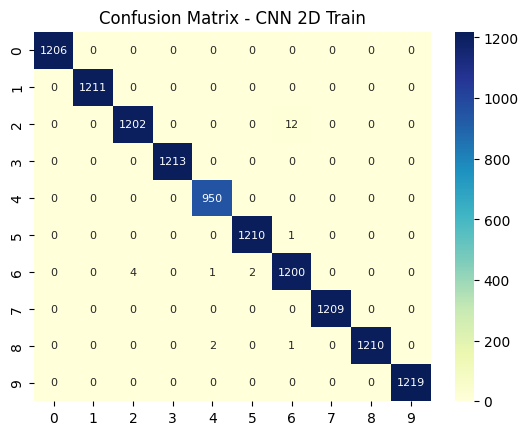

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


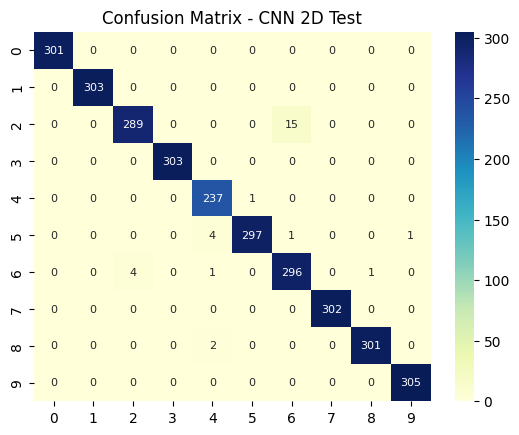

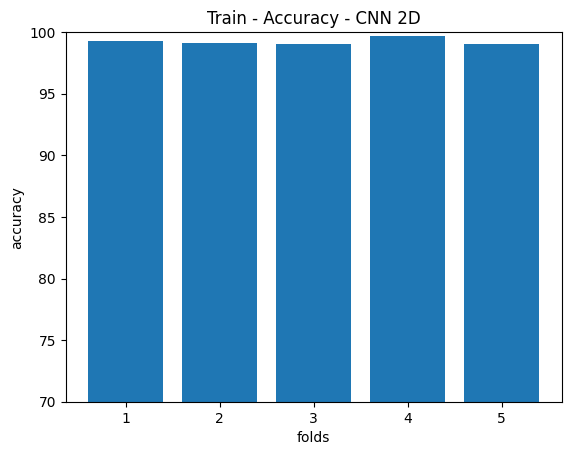

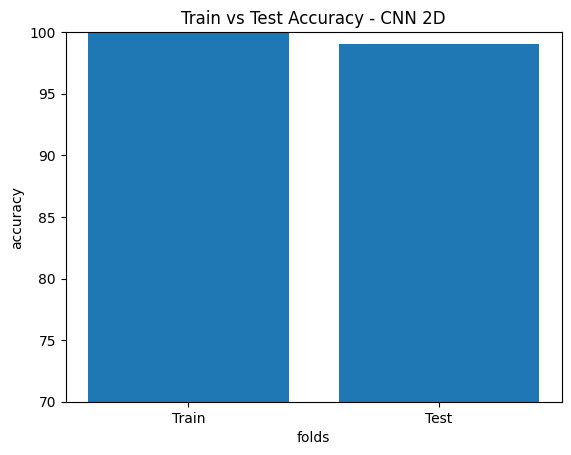

In [13]:
"""
# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Evaluation
# -----------------------------------------------------------------------------
"""

# Classification_2D.model.summary()

CNN_2D_train_accuracy = np.average(accuracy_train)*100
print('CNN 2D train accuracy =', CNN_2D_train_accuracy)
# print(accuracy_train)

CNN_2D_val_accuracy = np.average(accuracy_val)*100
print('CNN 2D validation accuracy =', CNN_2D_val_accuracy)
# print(accuracy_val)

CNN_2D_test_accuracy = np.average(accuracy_test)*100
print('CNN 2D test accuracy =', CNN_2D_test_accuracy)
# print(accuracy_test)

# Evaluate the accuracy of the model on the test set
# CNN_2D_test_loss, CNN_2D_test_accuracy = Classification_2D.model.evaluate(X_2D_test, y_2D_test)
# CNN_2D_test_accuracy*=100
# print('CNN 2D test accuracy =', CNN_2D_test_accuracy)


def ConfusionMatrix(Model, X, y):
  y_pred = np.argmax(Model.predict(X), axis=1)
  ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
  return ConfusionMat

# Plot results - CNN 2D
plt.figure(5)
plt.title('Confusion Matrix - CNN 2D Train') 
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_train, y_2D_train) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(6)
plt.title('Confusion Matrix - CNN 2D Test') 
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_test, y_2D_test) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(7)
plt.title('Train - Accuracy - CNN 2D')
plt.bar(np.arange(1,kSplits+1),[i*100 for i in accuracy_val])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70,100])
plt.show()

plt.figure(8)
plt.title('Train vs Test Accuracy - CNN 2D')
plt.bar([1,2],[CNN_2D_train_accuracy,CNN_2D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2],['Train', 'Test'])
plt.ylim([70,100])
plt.show()